##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/si-score/blob/master/analysis_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SI-Score demo: Evaluating models on small synthetic datasets

By Jessica Yung

*(Work in progress)*

In this colab, we will evaluate a model on small synthetic datasets and show its robustness to changes in object size, location and rotation angle.

You can adapt this colab to evaluate models of your choice on slightly differently configured synthetic datasets. Have fun! :)


In [ ]:
# if you want to load the main si-score dataset from tfds
# !pip install tfds-nightly

In [2]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib
import itertools
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

from multiprocessing.pool import ThreadPool
thread_pool = ThreadPool(100)

In [3]:
# Load model fine-tuned on ImageNet

# efficientnet
model_name = "EfficientNet-lite0"
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2"

# another choice
# model_name = "BiT-R50-ImageNet21k"
# model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"

imagenet_module = hub.KerasLayer(model_url)

## Code to import main SI-Score data from TFDS

In [ ]:
# Import siscore data from tfds

# variants: siscore/rotation, siscore/location, siscore/size
"""
dataset_name = 'siscore/size'
ds, info = tfds.load(name=dataset_name, with_info=True)
ds_test = ds['test']
num_examples = info.splits['test'].num_examples
ds_test = ds_test.batch(64)
"""

Dataset siscore downloaded and prepared to /root/tensorflow_datasets/siscore/size/1.0.0. Subsequent calls will reuse this data.


## Download mini dataset

### Download and set up chosen dataset

#### object size dataset

In [ ]:
!wget https://s3.us-east-1.amazonaws.com/si-score-dataset/object_size_mini.zip
!unzip object_size_mini.zip

# create 'test' dir in dataset dir to fit TFDS dataset structure
!mv object_size_mini/ test/
!mkdir object_size_mini/
!mv test/ object_size_mini/

#### object location dataset

In [ ]:
!wget https://s3.us-east-1.amazonaws.com/si-score-dataset/object_location_mini.zip
!unzip object_location_mini.zip

# create 'test' dir in dataset dir to fit TFDS dataset structure
!mv object_location_mini/ test/
!mkdir object_location_mini/
!mv test/ object_location_mini/

#### object rotation dataset

In [ ]:
!wget https://s3.us-east-1.amazonaws.com/si-score-dataset/object_rotation_mini.zip
!unzip object_rotation_mini.zip

# create 'test' dir in dataset dir to fit TFDS dataset structure
!mv object_rotation_mini/ test/
!mkdir object_rotation_mini/
!mv test/ object_rotation_mini/

### Build TFDS dataset

#### choose dataset

In [9]:
# TODO: set based on dataset chosen
folder_path = 'object_size_mini/'
plots_dir = 'plots/'

In [7]:
!mkdir plots/

In [10]:
builder = tfds.ImageFolder(folder_path)
print(builder.info)  # num examples, labels... are automatically calculated

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=1760,
    splits={
        'test': 1760,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



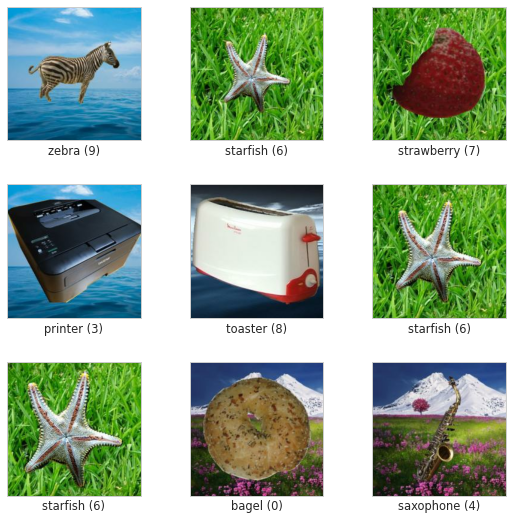

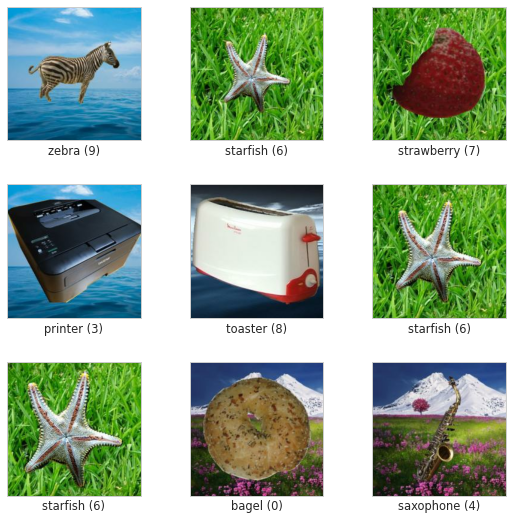

In [11]:
# there is only a test split in this dataset
ds = builder.as_dataset(split='test', shuffle_files=True)
tfds.show_examples(ds, builder.info)

In [12]:
# create dict that maps class strings (e.g. 'koala') to their corresponding ImageNet classes.

# read in foreground classes CSV. Each row has values (imagenet_class, class_string)
imagenet_class_mapping_df = pd.read_csv(f'{folder_path}/test/foreground_classes.csv')

# create dict
imagenet_class_mapping_dict = dict((row.values[1], row.values[0]) for _, row in imagenet_class_mapping_df.iterrows())

In [13]:
# Helper functions

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  # img_reshaped = tf.reshape(image, [-1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(image, tf.float32)  
  return image

def preprocess_image_tfds(features):
  features['image'] = image = tf.image.convert_image_dtype(features['image'], tf.float32)
  return features

def get_pred_top1_top5_acc(logits, labels):
  top5_preds = np.argsort(logits, axis=1)[:,-5::][:,::-1]
  preds = top5_preds[:,0]
  top1_acc = (preds == labels).astype(int)
  top5_acc = np.array([labels[i] in preds for i, preds in enumerate(top5_preds)]).astype(int)
  return preds, top1_acc, top5_acc

In [14]:
# Create pipeline to correct labels

keys_tensor = tf.convert_to_tensor(list(imagenet_class_mapping_dict.keys()))
vals_tensor = tf.convert_to_tensor(list(imagenet_class_mapping_dict.values()))
imagenet_class_mapping_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1)

def fix_labels(features):
  class_name = tf.compat.v2.strings.split(features['image/filename'], sep="/")[-2]
  image_id_str = tf.compat.v2.strings.split(features['image/filename'], sep="/")[-1]
  image_id_str = tf.compat.v2.strings.split(image_id_str, sep=".")[0]
  image_id = tf.strings.to_number(image_id_str, out_type=tf.int32)
  features['label'] = imagenet_class_mapping_table.lookup(class_name)
  features['image_id'] = image_id
  del features['image/filename']
  return features

ds_test = (ds.map(fix_labels)
        .map(preprocess_image_tfds)
        .batch(64))

### Evaluate model

In [15]:
# Evaluate model

# initialise
top1_accs_all = np.array([], dtype=int)
top5_accs_all = np.array([], dtype=int)
image_ids_all = np.array([], dtype=int)
preds_all = np.array([], dtype=int)
imagenet_labels_all = np.array([], dtype=int)

# Evaluate model
for features in ds_test:
  images = preprocess_image(features['image'])
  logits = imagenet_module(images)
  labels = features['label'].numpy()
  # Getting the model predictions and top1, top5 accuracy means we can save 
  # less in the exported numpy files or equivalent
  preds, top1_acc, top5_acc = get_pred_top1_top5_acc(logits, labels)
  image_ids = features['image_id'].numpy()

  top1_accs_all = np.concatenate((top1_accs_all, top1_acc))
  top5_accs_all = np.concatenate((top5_accs_all, top5_acc))
  image_ids_all = np.concatenate((image_ids_all, image_ids))
  preds_all = np.concatenate((preds_all, preds))
  imagenet_labels_all = np.concatenate((imagenet_labels_all, labels))

### Save results

In [16]:
data = np.vstack((image_ids_all, top1_accs_all, top5_accs_all, preds_all, imagenet_labels_all)).T

In [17]:
features_df = pd.DataFrame(data=data, columns=["image_id", "top1_acc", "top5_acc", "pred", "imagenet_label"])

In [18]:
features_df

,image_id,top1_acc,top5_acc,pred,imagenet_label
0,963,1,1,949,949
1,960,1,1,327,327
2,1742,1,1,951,951
3,1739,1,1,931,931
4,453,0,0,14,802
...,...,...,...,...,...
1755,874,0,1,5,949
1756,1736,1,1,340,340
1757,308,0,0,980,931
1758,251,0,0,124,776


In [19]:
# create dict with data for each model
features_dict = {model_name: {'features_df': features_df}}

## Analysis

In [20]:
#@title Helper functions used across more than one analysis 

def get_possible_values(attribute):
  return sorted(list(set(metadata_df[attribute])))  

def calc_average_acc_from_df(df, indices):
  top1_acc = np.mean(df.loc[indices]['top1_acc'])
  top5_acc = np.mean(df.loc[indices]['top5_acc'])
  return top1_acc, top5_acc

def calculate_group_top1_top5_accuracies(df_combined, group_indices_list):
  group_accuracies = []
  for group_indices in group_indices_list:
    acc = calc_average_acc_from_df(df_combined, group_indices)
    group_accuracies.append(acc)
  group_top1_accuracies = [i[0] for i in group_accuracies]
  group_top5_accuracies = [i[1] for i in group_accuracies]
  return group_top1_accuracies, group_top5_accuracies

def count_num_in_each_group(df, group_indices_list):
  group_counts = []
  for group_indices in group_indices_list:
    count = count_num_in_group(df_combined, group_indices)
    group_counts.append(count)
  return group_counts

def make_plots_subdir(plots_dir, plot_name):
  plots_subdir = os.path.join(plots_dir, f'{plot_name}')
  if not os.path.exists(plots_subdir):
    os.makedirs(plots_subdir)

def prettify_num_array(array, decimal_places=2):
  return [round(array[i], decimal_places) for i in range(len(array))]

def add_stats_to_feature_dict(plot_name, indices_list, model_names):
  for model_name in model_names:
    df_combined = pd.merge(metadata_df, features_dict[model_name]['features_df'], on='image_id')
    top1, top5 = calculate_group_top1_top5_accuracies(df_combined, indices_list)

    features_dict[model_name].update({f'{plot_name}_top1_accuracies': top1,
                                      f'{plot_name}_top5_accuracies': top5})
  
  return features_dict

### Object size

In [21]:
#@title Object size helper functions
def return_indices_with_area(area, min_pct_in_image=0.95):
  return np.array(metadata_df[(metadata_df['area'] == area) & metadata_df['pct_inside_image'] > min_pct_in_image].index)

def plot_area(model_names, k=1, is_save=True, file_format='pdf', plot_name='area'):
  fig = plt.figure()
  for model_name in model_names:
    plt.plot(areas, features_dict[model_name][f'object_size_top{k}_accuracies'], 'o', label=f'{model_name} Top-{k} acc')
  plt.title(f'Top-{k} Mean classification accuracy as object size varies')
  plt.xlabel('Object size (object area as % of background area)')
  plt.ylabel('Mean classification accuracy')
  # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.legend()
  plt.show()

In [22]:
# Load metadata
metadata_df = pd.read_csv(os.path.join(folder_path, 'test', 'metadata.csv'))

# set expt type etc.
expt_type = 'object_size'
model_names = features_dict.keys()

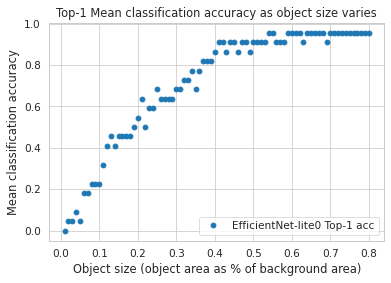

In [23]:
make_plots_subdir(plots_dir, expt_type)

areas = get_possible_values('area')
areas_pretty = prettify_num_array(areas)

# Optionally edit the min_pct_in_image argument if you want to filter out images where the object is less than e.g. 95% in the image.
# in which case you make min_pct_in_image=0.95.
def return_indices_with_area_filtered(area):
  return return_indices_with_area(area, min_pct_in_image=0)

area_indices_list = thread_pool.map(return_indices_with_area, areas)

features_dict = add_stats_to_feature_dict(expt_type, area_indices_list, model_names)

plot_area(model_names, plot_name='object_size_example', file_format="png")

### Location

In [41]:
#@title Location helper fns

# collect image IDs of images in each 'group' (with each coordinate location)
# dict of form {coords: indices, ...}

def return_indices_with_position(x_coord, y_coord, min_pct_in_image=0.95):
  return np.array(metadata_df[(metadata_df['x_coord'] == x_coord) & (metadata_df['y_coord'] == y_coord) & (metadata_df['pct_inside_image'] > min_pct_in_image)].index)

def get_indices_with_posn(coord_tuple, min_pct_in_image=0.95):
  x_coord, y_coord = coord_tuple
  indices = return_indices_with_position(x_coord, y_coord, min_pct_in_image=min_pct_in_image)
  return indices

def plot_heatmap(heatmap_data, xticklabels, yticklabels, title):
  fig = plt.figure()
  framewidth = 5
  ax = sns.heatmap(heatmap_data, xticklabels=xticklabels, yticklabels=yticklabels)
  ax.axhline(y=0, color='k',linewidth=framewidth)
  ax.axhline(y=heatmap_data.shape[1], color='k',linewidth=10)
  ax.axvline(x=0, color='k',linewidth=framewidth)
  ax.axvline(x=heatmap_data.shape[0], color='k',linewidth=10)
  plt.title(title)
  plt.xlabel('Normalised x-coord of object centre')
  plt.ylabel('Normalised y-coord of object centre')
  plt.show()
  return fig

def plot_heatmaps(model_names, k=1, plot_name='location20_area02', is_save=True, file_format='pdf'):
  make_plots_subdir(plots_dir, plot_name)
  for model_name in model_names:
    topk = features_dict[model_name][f'{expt_type}_top{k}_accuracies']
    heatmap_side_length = int(np.sqrt(np.array(topk).shape[0]))
    heatmap_shape = (heatmap_side_length, heatmap_side_length)
    heatmap_data_topk = np.array(topk).reshape(heatmap_shape).T
    # title = f"Mean top-{k} accuracy \n as object position varies\n{model_name}\n(Objects 80%+ in image,\nobject area = 10% of image)"
    title = f"Mean top-{k} accuracy ({model_name})"

    x_coords_pretty = [round(x, 2) for x in x_coords]
    y_coords_pretty = [round(y, 2) for y in y_coords]

    fig = plot_heatmap(heatmap_data_topk, x_coords_pretty, y_coords_pretty, title=title)

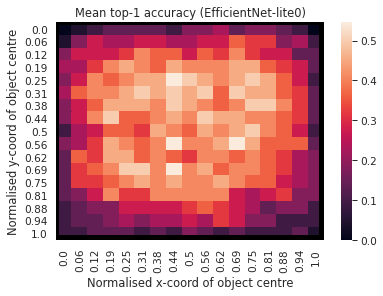

In [44]:
# Load metadata
metadata_df = pd.read_csv(os.path.join(folder_path, 'test', 'metadata.csv'))

# set expt type etc.
expt_type = 'object_location'
model_names = features_dict.keys()

x_coords = get_possible_values('x_coord')
y_coords = get_possible_values('y_coord')
coords = list(itertools.product(x_coords, y_coords))

# Optionally edit the min_pct_in_image argument if you want to filter out images where the object is less than e.g. 95% in the image.
# in which case you make min_pct_in_image=0.95.
def get_indices_with_posn_filtered(coord_tuple):
  return get_indices_with_posn(coord_tuple, min_pct_in_image=0)

posn_indices_list = thread_pool.map(get_indices_with_posn_filtered, coords)

features_dict = add_stats_to_feature_dict(expt_type, posn_indices_list, model_names)

plot_heatmaps(model_names, is_save=True, plot_name='location_example', file_format="png")

### Rotation

In [61]:
#@markdown rotation helper functions

def shift_list(array, split_point):
  return array[split_point:] + array[:split_point + 1]

def get_indices_with_angle(angle, area=None):
  if area is None:
    return np.array(metadata_df[(metadata_df['rotation'] == angle) & metadata_df['pct_inside_image'] > 0.95].index)
  else:
    return np.array(metadata_df[(metadata_df['rotation'] == angle) & (metadata_df['area'] == area)].index)

In [59]:
# Load metadata
metadata_df = pd.read_csv(os.path.join(folder_path, 'test', 'metadata.csv'))

In [62]:
angles = get_possible_values('rotation')
rotations_indices_list = thread_pool.map(get_indices_with_angle, angles)

In [63]:
plot_name = "rotation"
indices_list = rotations_indices_list
for model_name in model_names:
  df_combined = pd.merge(metadata_df, features_dict[model_name]['features_df'], on='image_id')
  top1, top5 = calculate_group_top1_top5_accuracies(df_combined, indices_list)

  features_dict[model_name].update({f'{plot_name}_top1_accuracies': top1,
                                    f'{plot_name}_top5_accuracies': top5})

In [65]:
expt_type = plot_name
frames = []
for model_name in model_names:
  data = np.array(features_dict[model_name][f'{expt_type}_top1_accuracies'])
  frames.append(data / np.max(data) * 100)

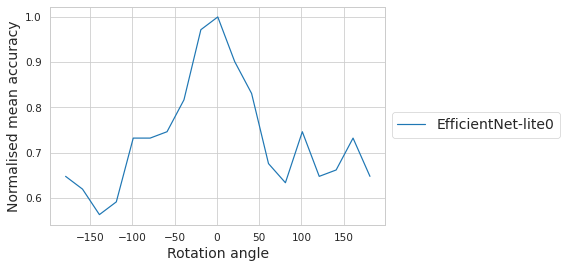

In [68]:
plot_name = 'rotation'
split_point = np.argwhere(np.array(angles) == 181)[0][0]
k = 1
file_format = 'pdf'

for model_name in model_names:
  top1 = features_dict[model_name][f'{plot_name}_top{k}_accuracies']
  top1 = shift_list(top1, split_point)
  angles_copy = shift_list(angles, split_point)
  angles_copy = np.array(angles_copy) - np.array([360] * 9 + [0] * 10)
  top1 = top1 / np.max(top1)
  plt.plot(angles_copy, top1, label=f'{model_name}')
  # plt.plot(angles, features_dict[model_name][f'{plot_name}_top5_accuracies'], 'o', label=f'{model_name} Top-5 acc')
# plt.title(f'Top-{k} mean classification accuracy as rotation angle varies')
plt.xlabel('Rotation angle', fontsize=14)
plt.ylabel('Normalised mean accuracy', fontsize=14)
plt.legend(loc=(1.02, 0.4), fontsize=14)
# plt.legend(loc=(0, 0.45), ncol=2, fontsize=12)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
filepath = os.path.join(plots_dir, f'{plot_name}_top{k}')